# Using QR Factorization to Analyze Trappist-1 data

One of the ways that planetary scientists detect exoplanets that are many light years away is by
detecting the dimming of a distant sun as a planet passes in front of it. It seems like this can’t provide a
lot of data about a distant system, but by using linear regression, we can estimate the period and from
there, derive a lot of other information about the planetary system we are looking at.

There are plenty of ways to do linear regression, but I wanted to try writing code by hand that would let me analyze this data, using techniques learned in my Numerical Computation class. My astronomy professor, Zach Berta-Thompson, helped me by providing the following data table:

<img src="trappist_times.png">

This data has two values: the epoch number, or the number of the transit, and a time in
barycentric Julian days(BJD). BJD has units of days, with an offset for Julian days, adjusted for the solar system. The epoch is the count of the orbits of the planet. These two numbers have a linear relationship, which means I can apply a regression line and get an estimate of the slope and intercept. This slope is in the units of days/epoch, meaning it will give us the estimated value of the period of the planet.

If you plot the data, you can see the linear relationship.

To begin with, I took the Trappist-1 data and applied a matrix-based least
squares equation. This involves creating a matrix A, with the first column being the x values, here the
epoch data, and the second being all ones. We set that equal to a 1xn matrix of the y data, here the
barycentric Julian days. This basically means we can solve for y = ax+b, where y and x are from the
data and a and b will be the slope and y-intercept of the best fit line.

In [41]:
import matplotlib.pylab as plt
import numpy as np
import random
import math

# Data from image
epochb = np.array([0,2,6,8,10,12,15,26,28])
bjdb = np.array([7322.5161,7325.5391,7331.5803,7334.60490,7337.6249,7340.6474,7345.18011,7361.79960,7364.82137])

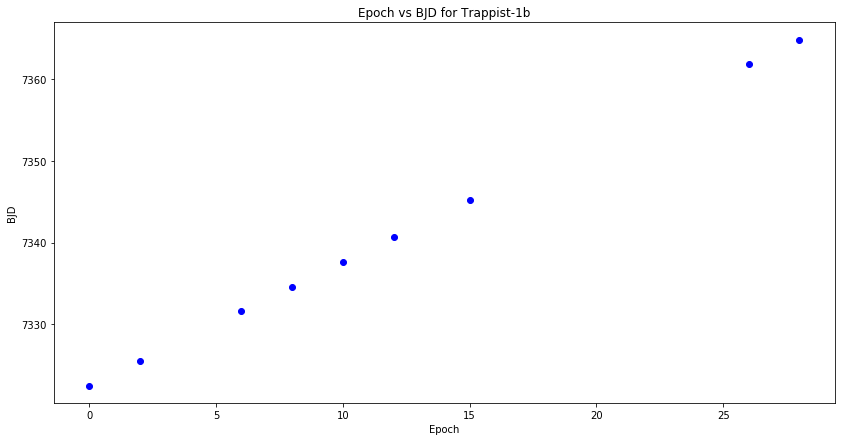

In [42]:
plt.figure(figsize=[14,7])
plt.plot(epochb, bjdb, 'bo')
plt.title("Epoch vs BJD for Trappist-1b")
plt.xlabel("Epoch")
plt.ylabel("BJD")
plt.show()

To start, I attempted to use the root mean squares method to create a regression line. This involves putting the points in a matrix and attempting to solve Ax=y, where A is the design matrix (the list of epoch values prepended with a column of ones to account for the intercept) and y is the value we are attempting to predict, i.e. the time in BJD. This method returns a 2x1 matrix, consisting of the intercept and the slope of the predicted line.

In [43]:
# Root Mean squares using A^T*A*x = A^T*b method
def rootms(x, y):
    if len(x) != len(y):
        print("Error: Input array sizes must match.")
        return -1
    a1 = [1 for i in range(0, len(x))]

    # Slightly backwards - easier to find A^T and then transpose that ([A^T]^T = A)
    aT = np.matrix([y, a1])
    a = np.transpose(aT)
    b = np.transpose(np.matrix([x]))
    print("Condition number of matrix: {}".format(np.linalg.cond(a)))

    x = np.linalg.inv(aT*a)*aT*b

    return x

line = rootms(epochb, bjdb)
rmsintercept = line.item(1)
rmsslope = line.item(0)
print("Predicted Intercept: {}".format(rmsintercept))
print("Predicted slope: {}".format(rmsslope))

Condition number of matrix: 3878624.662889085
Predicted Intercept: -4846.487281662674
Predicted slope: 0.6618608902920844


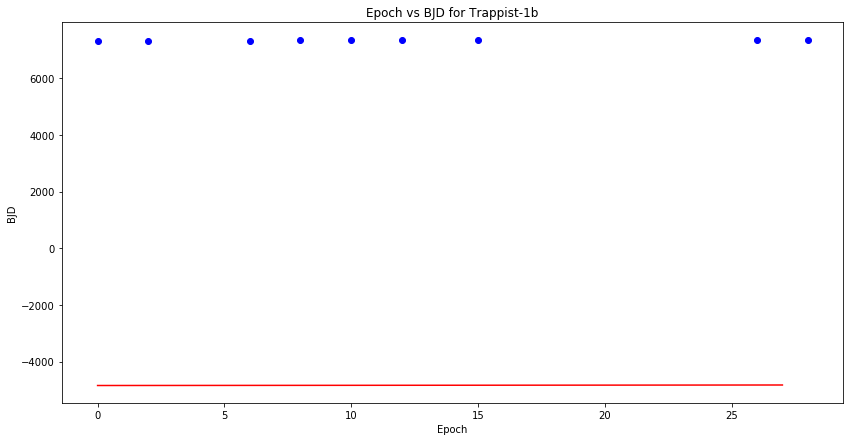

In [44]:
x = np.arange(epochb[0], epochb[-1])
y = rmsslope*x+rmsintercept

plt.figure(figsize=[14,7])
plt.plot(epochb, bjdb, 'bo')
plt.plot(x,y, color='red', label='RMS Line')
plt.title("Epoch vs BJD for Trappist-1b")
plt.xlabel("Epoch")
plt.ylabel("BJD")
plt.show()

Well, that isn't right. What's happening here is a little subtle. This method is sensitive to the values within the matrices, and the accuracy can be measured by the _conditionality_ of the matrix. As you can see above, the condition number of the A matrix used is $3878624.662889085$. The larger the number, the more _ill-conditioned_ a matrix is, and  the greater the error. This has to do with the way the computer stores the numbers - they aren't perfect. In the case of extremely small numbers, there is some degree of accuracy that is lost, and if the method is sensitive to changes in conditions, as RMS is, this can quickly lead to a snowball of error. Therefore, this method isn't going to work. 

Luckily, there is another method that can be used for linear regression, known as QR Factorization. It isn't as sensitive to errors as RMS. My method uses householder reflectors to calculate Q and R, in a complicated method that I won't cover in detail here. I got my information from [Sauer's Numerical Analysis, 2nd edition book](https://www.amazon.com/Numerical-Analysis-2nd-Timothy-Sauer/dp/0321783670).

In [47]:
# Project a vector x into n-1 dimensional space
def project(x):
    cond = 0
    w = np.zeros(len(x))
    for r in x:
        cond += math.pow(r, 2)
    w[0] = math.sqrt(cond)
    w = np.transpose(np.matrix(w))

    v = w - x
    P = (v * np.transpose(v)) / (np.transpose(v) * v)
    return np.identity(len(P)) - 2 * P

# given a 2xn matrix A and a 1xn matrix b, will solve for a root mean
# squares solution using QR factorization. Returns the x matrix.
def householder(epochb,bjdb):
    a1 = [1 for i in range(0, len(bjdb))]

    # Slightly backwards - easier to find A^T and then transpose that ([A^T]^T = A)
    aT = np.matrix([epochb, a1])
    A = np.transpose(aT)
    b = np.transpose(np.matrix(bjdb))
    
    # First column = x
    x=A[:,0:1]

    H1 = project(x)
    H1A = H1*A

    # Value for H2 - second column excluding the first value to avoid messing it up
    x = H1A[1:,1:]
    H2_int = project(x)

    # Put in the correct form - first row and column as ID matrix, again to avoid messing up first value.
    H2 = np.matrix(np.zeros(len(np.array(x))))
    H2 = np.concatenate((H2, H2_int))
    id = np.zeros(len(np.array(x))+1)
    id[0] = 1
    H2 = np.concatenate((np.transpose(np.matrix(id)), H2), axis=1)

    R = H2*H1*A

    Q = H1*H2
    R = R[:2, :2]
    d = (np.transpose(Q)*b)
    d = d[:2]

    # Solve Rx = d where R is upper nxn of R, and d is upper n of Q^T*b
    x = np.linalg.inv(R)*d
    return x

hh = householder(epochb, bjdb)
hhintercept = hh.item(1)
hhslope = hh.item(0)
print("Householder intercept: {}".format(hhintercept))
print("Householder slope: {}".format(hhslope))

Householder intercept: 7322.51648765625
Householder slope: 1.5108915055490684


Let's plot the new values of the intercept and slope to compare.

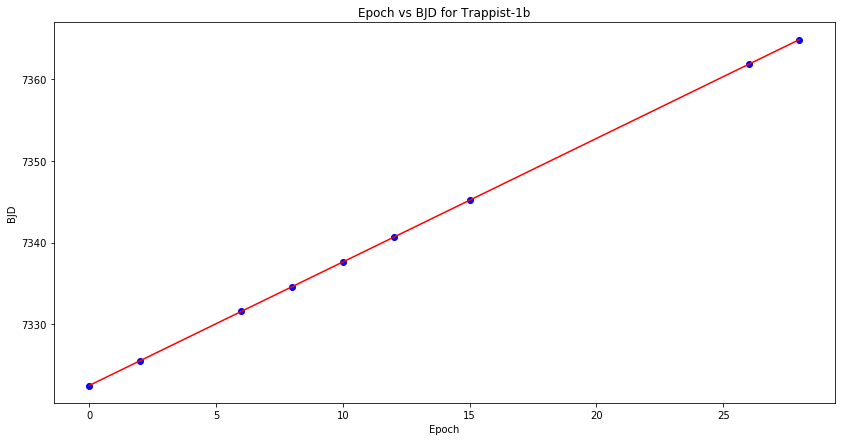

In [49]:
x = np.arange(epochb[0], epochb[-1]+1)
y = hhslope*x+hhintercept

plt.figure(figsize=[14,7])
plt.plot(epochb, bjdb, 'bo')
plt.plot(x,y, color='red', label='HH Line')
plt.title("Epoch vs BJD for Trappist-1b")
plt.xlabel("Epoch")
plt.ylabel("BJD")
plt.show()

As you can see, this line is a lot closer to the points were were looking at. 

From the slope of this line, I can estimate the period of Trappist-1b as $1.51089150554$ days. 

The official period, in days, of Trappist-1 b is $1.51087081±0.00000060$ days. This means I have a relative error of $1.94 *10^{-5}$. My estimation is off from the official period by 2.53 seconds. 

Linear regression is extremely useful, although it's more common for people to use Stochastic gradient descent that QR factorization. However, it's interesting to see the ways something so small, like the error in computer numbers, can affect a method so heavily. 

##### Sources:
Sauer, Numerical Analysis, 2nd edition

Gillon et al, "Temperate Earth-sized planets transiting a nearby ultracool dwarf star." http://www.eso.org/public/archives/releases/sciencepapers/eso1615/eso1615a.pdf

## Code and additional analysis on [my github](https://github.com/ceilingcranes/trappist-analysis).